Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

('Most common words (+UNK)', [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)])
('Sample data', [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156])


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:12]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working'])

with num_skips = 2 and skip_window = 1:
('    batch:', ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term'])
('    labels:', ['as', 'anarchism', 'originated', 'a', 'term', 'as', 'of', 'a'])

with num_skips = 4 and skip_window = 2:
('    batch:', ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a'])
('    labels:', ['a', 'anarchism', 'term', 'originated', 'originated', 'as', 'of', 'term'])


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.833504
Nearest to five: koans, robbins, luxemburg, undeniable, analyze, salvador, extensive, anatomists,
Nearest to no: evolutionist, undone, robe, gte, prophesies, mia, hartmann, organizing,
Nearest to i: devolution, pornography, sarris, retelling, bootleg, quarrelled, comparative, misc,
Nearest to more: birds, interwoven, metabolic, remarried, panacea, saltpeter, forfeited, becquerel,
Nearest to after: tinymud, gok, plenipotentiary, slays, indicate, encircling, allahabad, nyquist,
Nearest to see: reawakened, nuke, sor, pleased, erupting, vultures, karamanlis, manet,
Nearest to also: clogged, hemlock, concentrated, compactly, kinks, steamers, avoids, guerrillas,
Nearest to however: distinguished, simulating, ricans, gokturk, rupert, oaths, bytes, orbit,
Nearest to would: cephalon, loses, ipsec, aalen, obsessive, casale, elvis, smuts,
Nearest to three: symbolise, mis, horsepower, pax, natchez, paragliding, beggar, plantations,
Nearest to to: druid,

In [8]:
num_points = 500

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

/Users/somnath/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


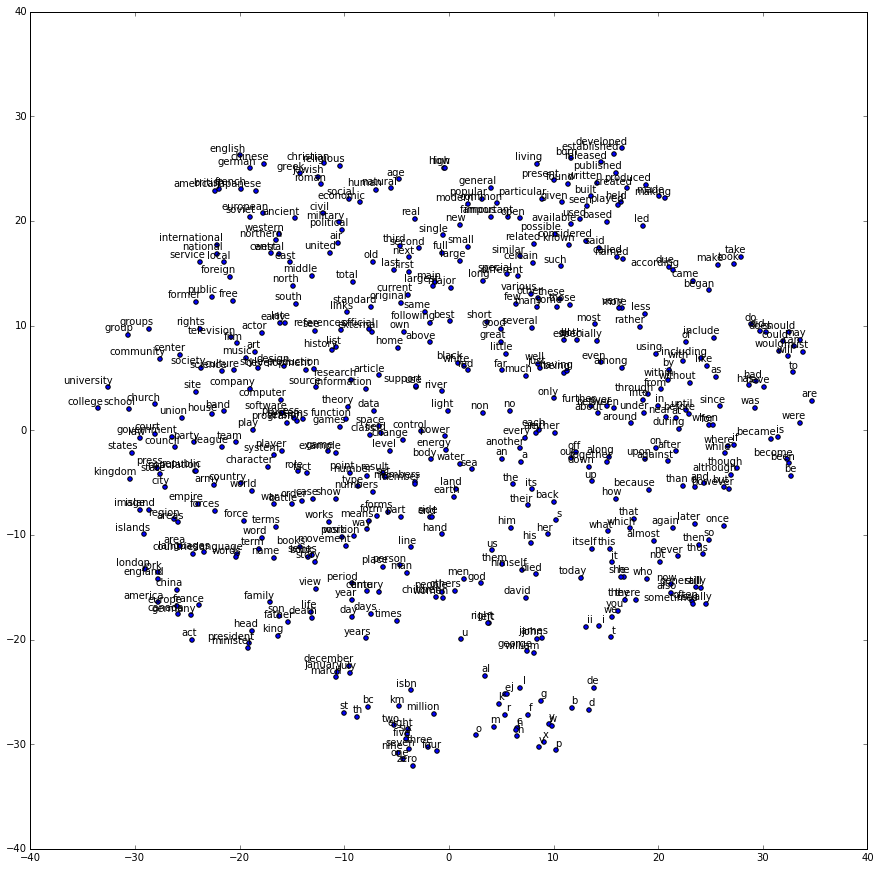

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [10]:
data_index = 0

def generate_cbow_batch(batch_size, num_skips, skip_window):
    global data_index
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)

    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)

    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    for i in range(batch_size):
        context = skip_window  # target label at the center of the buffer
        context_to_avoid = [ skip_window ]

        for j in range(num_skips):
            while context in context_to_avoid:
                context = random.randint(0, span - 1)

            context_to_avoid.append(context)
            batch[i, j] = buffer[context]
            labels[i, 0] = buffer[skip_window]

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:12]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch_size = 8
    batch, labels = generate_cbow_batch(batch_size, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    for i in range(batch_size):
        context = [reverse_dictionary[bi] for bi in batch[i]]
        label = reverse_dictionary[labels[i][0]]
        print context, ' -> ', label

('data:', ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working'])

with num_skips = 2 and skip_window = 1:
['anarchism', 'as']  ->  originated
['originated', 'a']  ->  as
['as', 'term']  ->  a
['a', 'of']  ->  term
['abuse', 'term']  ->  of
['of', 'first']  ->  abuse
['used', 'abuse']  ->  first
['first', 'against']  ->  used

with num_skips = 4 and skip_window = 2:
['term', 'anarchism', 'a', 'originated']  ->  as
['originated', 'of', 'term', 'as']  ->  a
['abuse', 'a', 'of', 'as']  ->  term
['abuse', 'a', 'term', 'first']  ->  of
['used', 'term', 'of', 'first']  ->  abuse
['abuse', 'against', 'used', 'of']  ->  first
['first', 'abuse', 'early', 'against']  ->  used
['working', 'used', 'early', 'first']  ->  against


In [11]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many context words to use to predict the target
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, num_skips])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed_all = tf.nn.embedding_lookup(embeddings, train_dataset)
    embed = tf.reduce_sum(embed_all, reduction_indices=1)

    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))


    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm

In [12]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0

    for step in range(num_steps):
        batch_data, batch_labels = generate_cbow_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0

    cbow_final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.601126
Average loss at step 2000: 4.094184
Average loss at step 4000: 3.549897
Average loss at step 6000: 3.381021
Average loss at step 8000: 3.232369
Average loss at step 10000: 3.173047
Average loss at step 12000: 3.202221
Average loss at step 14000: 3.150956
Average loss at step 16000: 3.173577
Average loss at step 18000: 3.127653
Average loss at step 20000: 2.988301
Average loss at step 22000: 3.075848
Average loss at step 24000: 3.033350
Average loss at step 26000: 3.001025
Average loss at step 28000: 3.027569
Average loss at step 30000: 3.005802
Average loss at step 32000: 2.833062
Average loss at step 34000: 2.953414
Average loss at step 36000: 2.948436
Average loss at step 38000: 2.935871
Average loss at step 40000: 2.933054
Average loss at step 42000: 2.946454
Average loss at step 44000: 2.955773
Average loss at step 46000: 2.902620
Average loss at step 48000: 2.871385
Average loss at step 50000: 2.841786
Average loss at step 52000: 2.8900

In [14]:
# wordid = random.randint(0, vocabulary_size)
wordid = dictionary['asia']
test_word = reverse_dictionary[wordid]

skip_gram_sim = np.dot(final_embeddings, final_embeddings[wordid, ])
cbow_sim = np.dot(cbow_final_embeddings, cbow_final_embeddings[wordid, ])

top_k = 8 # number of nearest neighbors

skip_gram_nearest = (-skip_gram_sim).argsort()[1:top_k+1]
cbow_nearest = (-cbow_sim).argsort()[1:top_k+1]

skip_gram_log = 'Skip Gram Nearest to %s:' % test_word
cbow_log = 'CBOW Nearest to %s:' % test_word
for k in range(top_k):
    close_word = reverse_dictionary[skip_gram_nearest[k]]
    skip_gram_log = '%s %s,' % (skip_gram_log, close_word)
    
    close_word = reverse_dictionary[cbow_nearest[k]]
    cbow_log = '%s %s,' % (cbow_log, close_word)

print skip_gram_log
print cbow_log

Skip Gram Nearest to asia: africa, europe, abijah, america, southwest, kentucky, inappropriate, ag,
CBOW Nearest to asia: africa, europe, pakistan, china, sacha, asian, brazil, france,
